In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, IsolationForest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 
from xgboost import XGBRegressor
import shap

# Load the dataset
data = pd.read_csv("data.csv")

# Display basic information about the dataset
print("Dataset Information:")
print(data.info())
print(data.head())
print("\nDataset Description:")
print(data.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1152 non-null   object 
 1   dfy     1152 non-null   float64
 2   infl    1152 non-null   float64
 3   svar    1152 non-null   float64
 4   de      1152 non-null   float64
 5   lty     1152 non-null   float64
 6   tms     1152 non-null   float64
 7   tbl     1152 non-null   float64
 8   dfr     1152 non-null   float64
 9   dp      1152 non-null   float64
 10  dy      1152 non-null   float64
 11  ltr     1152 non-null   float64
 12  ep      1152 non-null   float64
 13  b/m     1152 non-null   float64
 14  ntis    1152 non-null   float64
 15  mr      1152 non-null   float64
 16  R       1152 non-null   float64
dtypes: float64(16), object(1)
memory usage: 153.1+ KB
None
         date     dfy      infl      svar        de     lty     tms     tbl  \
0  1927-01-31  0.0100  0.00568


Missing Values:
date    0
dfy     0
infl    0
svar    0
de      0
lty     0
tms     0
tbl     0
dfr     0
dp      0
dy      0
ltr     0
ep      0
b/m     0
ntis    0
mr      0
R       0
dtype: int64


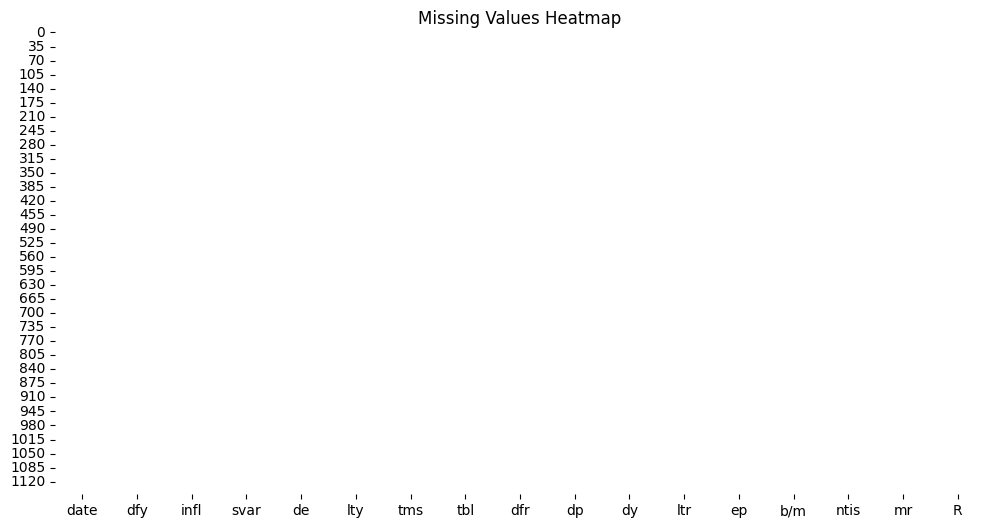

In [2]:
# Check for missing values and visualize
print("\nMissing Values:")
print(data.isnull().sum())

# Convert True/False to 1/0
null_map = data.isnull().astype(int)

plt.figure(figsize=(12, 6))  # Optional: adjust figure size for clarity
sns.heatmap(null_map, cbar=False, cmap=["white", "black"])
plt.title("Missing Values Heatmap")
plt.show()


(1152, 17)
R       1.000000
b/m     0.080325
mr      0.076928
dy      0.063345
ep      0.056292
dp      0.055683
dfy     0.050634
ltr     0.047326
tms     0.040256
dfr     0.024690
svar    0.014068
de      0.008739
date   -0.006666
infl   -0.037758
lty    -0.044029
tbl    -0.057317
ntis   -0.066061
Name: R, dtype: float64


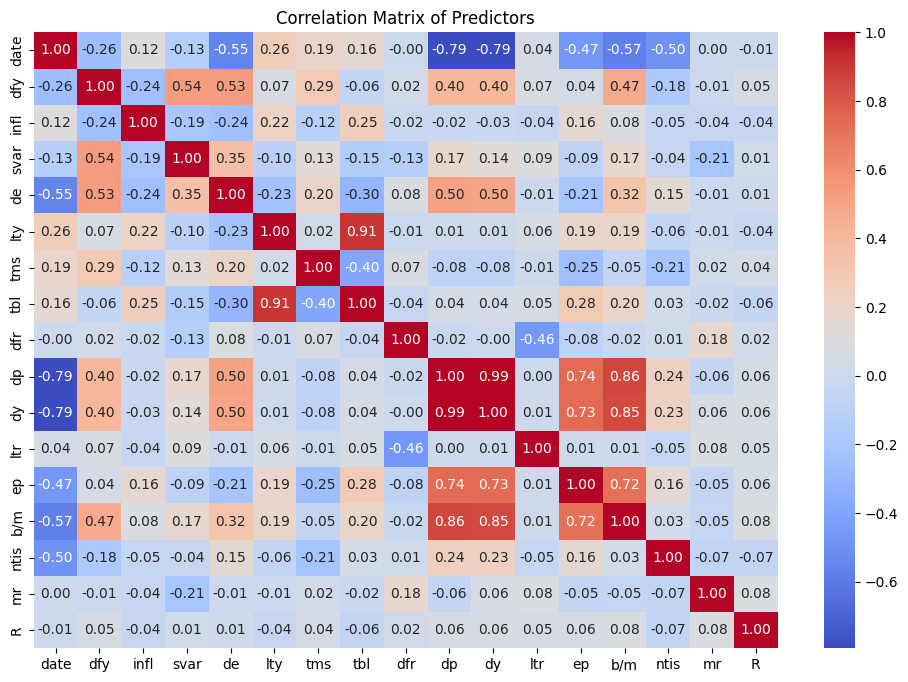

(1152, 17)


In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert the date column to datetime for clarity
data['date'] = pd.to_datetime(data['date'])

print(data.shape)

# Correlation analysis
correlations = data.corr()
print(correlations['R'].sort_values(ascending=False))  # Correlation of all features with R

# Visualize correlations between predictors
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()



# # Handle multicollinearity using Variance Inflation Factor (VIF) - As the model performance did not improve with this, the code is deactivated

# # Ensure there are no missing or infinite values
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
# data.dropna(inplace=True)

# # Calculate VIF for each feature
# X = data.drop(columns=["date", "R"])
# vif_data = pd.DataFrame()
# vif_data["feature"] = X.columns
# vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# print("\nVariance Inflation Factor (VIF) before handling multicollinearity:")
# print(vif_data)

# # Drop features with high VIF (e.g., VIF > 10)
# high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"]
# X_reduced = X.drop(columns=high_vif_features)

# # Recalculate VIF for the reduced set of features
# vif_data_reduced = pd.DataFrame()
# vif_data_reduced["feature"] = X_reduced.columns
# vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

# print("\nVariance Inflation Factor (VIF) after handling multicollinearity:")
# print(vif_data_reduced)

# # Update the data with reduced features
# data = data[["date", "R"] + list(X_reduced.columns)]

# # Correlation analysis
# correlations = data.corr()
# print(correlations['R'].sort_values(ascending=False))  # Correlation of all features with R

# # Visualize correlations between predictors
# plt.figure(figsize=(12, 8))
# sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix of Predictors")
# plt.show()

print(data.shape)

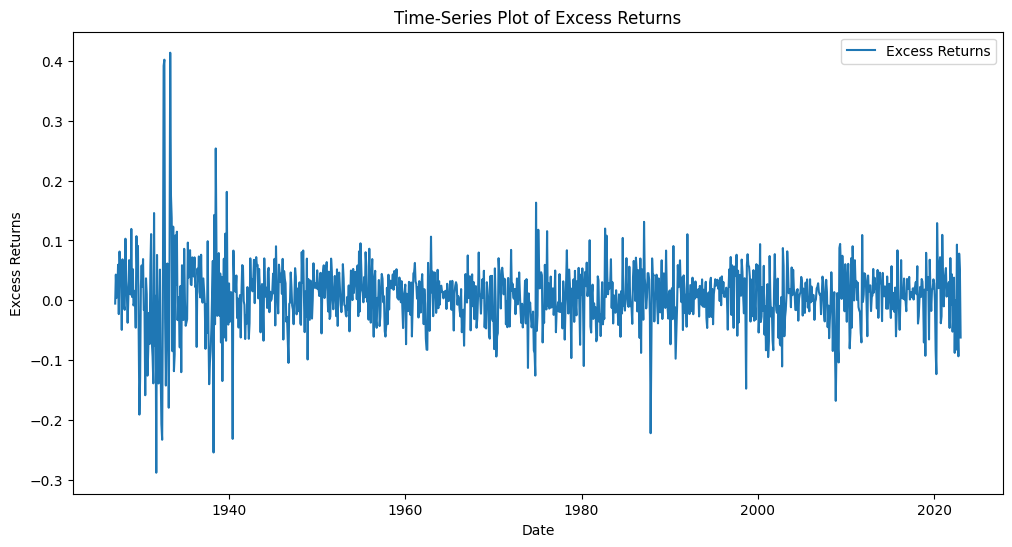

(1152, 17)

In [4]:

# Plot the time-series of the target variable
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['R'], label="Excess Returns")
plt.title("Time-Series Plot of Excess Returns")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.show()
data.shape

In [5]:

# Handle missing values using forward-fill if any
print("\nMissing Values Before Forwared Filling:")
print(data.isnull().sum())

data.ffill(inplace=True)
print("\nMissing Values After Forwared Filling:")
print(data.isnull().sum())

# Reset the index
data.reset_index(drop=True, inplace=True)

print("\nAfter removing NaN values:")
print(data.info())
print(data.head())


Missing Values Before Forwared Filling:
date    0
dfy     0
infl    0
svar    0
de      0
lty     0
tms     0
tbl     0
dfr     0
dp      0
dy      0
ltr     0
ep      0
b/m     0
ntis    0
mr      0
R       0
dtype: int64

Missing Values After Forwared Filling:
date    0
dfy     0
infl    0
svar    0
de      0
lty     0
tms     0
tbl     0
dfr     0
dp      0
dy      0
ltr     0
ep      0
b/m     0
ntis    0
mr      0
R       0
dtype: int64

After removing NaN values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1152 non-null   datetime64[ns]
 1   dfy     1152 non-null   float64       
 2   infl    1152 non-null   float64       
 3   svar    1152 non-null   float64       
 4   de      1152 non-null   float64       
 5   lty     1152 non-null   float64       
 6   tms     1152 non-null   float64       
 7   tbl     1152 non-

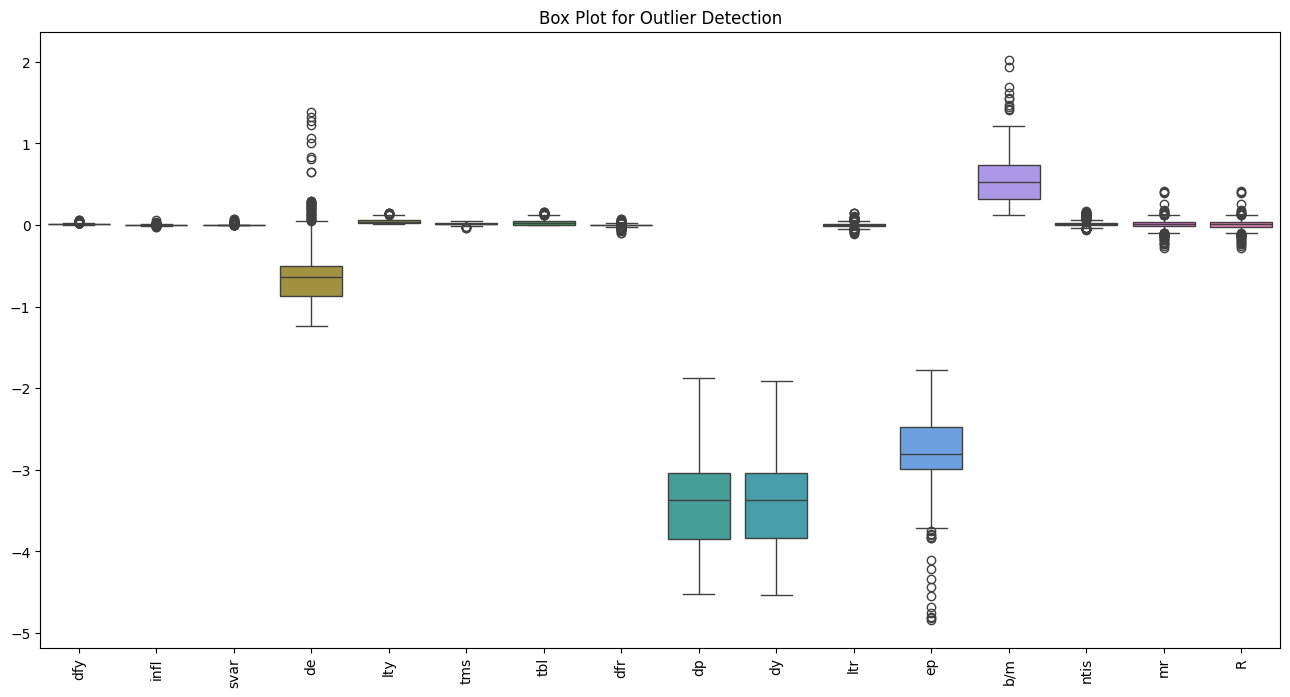

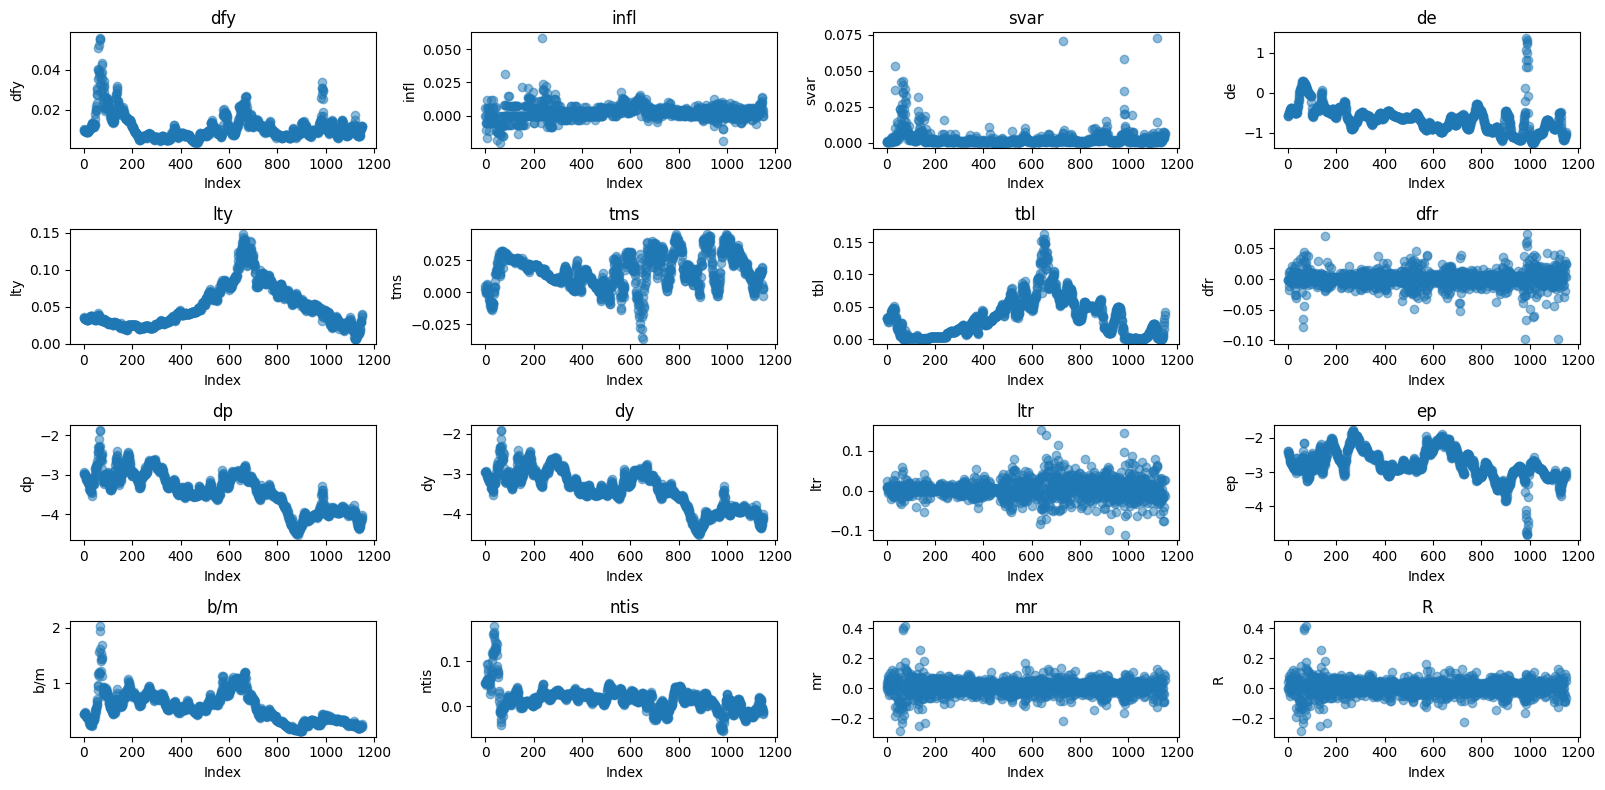

In [6]:
# Handling Outliers: The following approach was followed combining statistical, visual, and machine learning techniques:
# - Visualized using box plots and scatter plots.
# - Identified outliers with IQR method and Isolation Forest (machine learning).
# - IQR: Values outside [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] are outliers.
# - Isolation Forest: Detects anomalies by isolating points with fewer splits.
# - Outliers detected by both methods were handled using the IQR method.
# But the model performance did not improve hence only visualization code is kept here by commenting out the rest of the code

# print("Data shape before handling outliers:", data.shape)
# print(data.shape)

#1. Use a box plot to visualize potential outliers
plt.figure(figsize=(16, 8))
sns.boxplot(data=data.drop(columns=['date']))
plt.title("Box Plot for Outlier Detection")
plt.xticks(rotation=90)
plt.show()

#Use a scatter plot to visualize potential outliers
plt.figure(figsize=(16, 8))
for i, col in enumerate(data.drop(columns=['date']).columns, 1):
    plt.subplot(4, 4, i)
    plt.scatter(data.index, data[col], alpha=0.5)
    plt.title(col)
    plt.xlabel("Index")
    plt.ylabel(col)
plt.tight_layout()
plt.show()

#the following code is de-activated on purpose as there is no model improvement.

# # 2. Apply IQR for quantitative identification
# Q1 = data.quantile(0.25)
# Q3 = data.quantile(0.75)
# IQR = Q3 - Q1

# # Define outlier thresholds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identify outliers
# outliers = ((data < lower_bound) | (data > upper_bound))
# print("\nOutliers detected using IQR:")
# print(outliers.sum())

# # 3. Validate results using a machine learning method -  Isolation Forest
# iso_forest = IsolationForest(contamination=0.01, random_state=42)
# outlier_pred = iso_forest.fit_predict(data.drop(columns=['date']))
# outlier_pred = pd.Series(outlier_pred, name="outlier_pred", index=data.index)

# # # Count the number of outliers detected by Isolation Forest
# # print("\nOutliers detected using Isolation Forest:")
# # print(outlier_pred.value_counts())

# # # Print the total number of outliers detected by Isolation Forest
# # total_outliers_iso_forest = (outlier_pred == -1).sum()
# # print("\nTotal outliers detected by Isolation Forest:", total_outliers_iso_forest)

# # Print the number of outliers in each column identified by Isolation Forest
# print("\nNumber of outliers in each column identified by Isolation Forest:")
# iso_forest_outliers = data[outlier_pred == -1]
# print(iso_forest_outliers.drop(columns=['date']).apply(lambda x: (x != np.nan)).sum())

# # # Print the number of outliers in each column identified by Isolation Forest
# # print("\nNumber of outliers in each column identified by Isolation Forest:")
# # iso_forest_outliers = data[outlier_pred == -1]
# # print(iso_forest_outliers.drop(columns=['date']).apply(lambda x: (x != np.nan)).sum())


# # 4. Handle the outliers by capping using IQR method - only those detected by both methods
# handled_outliers_count = pd.Series(0, index=data.columns)
# for col in data.columns:
#     if col not in ['date', 'R']: # nolint
#         combined_outliers = outliers[col] & (outlier_pred == -1)
#         data[col] = np.where(combined_outliers & (data[col] < lower_bound[col]), lower_bound[col], data[col]) # nolint
#         data[col] = np.where(combined_outliers & (data[col] > upper_bound[col]), upper_bound[col], data[col]) # nolint
#         handled_outliers_count[col] = combined_outliers.sum()

# print("\nTotal number of outliers handled along with column names:")
# print(handled_outliers_count[handled_outliers_count > 0])




# print("\nData after capping outliers detected by both methods:")
# print(data.describe())

# print("Data shape after handling outliers:", data.shape)
# print(data.shape)

In [7]:
# Add interaction terms
data["tms_infl"] = data["tms"] * data["infl"]
data["svar_dfy"] = data["svar"] * data["dfy"]
data["de_tbl"] = data["de"] * data["tbl"]
print(data.shape)
print(data.head())

# Add squared term for 'infl'
data["infl_squared"] = data["infl"] ** 2

# Create lagged features
data['R_lag1'] = data['R'].shift(1)  # Lagged excess returns (1 month)
data['R_lag2'] = data['R'].shift(2)  # Lagged excess returns (2 month)
data['R_lag3'] = data['R'].shift(3)  # Lagged excess returns (3 month)
data['de_lag1'] = data['de'].shift(1)  # Lagged dividend-price ratio
data['ep_lag1'] = data['ep'].shift(1)  # Lagged earnings-price ratio
data['infl_lag1'] = data['infl'].shift(1)  # Lagged inflation
data['tbl_lag1'] = data['tbl'].shift(1)  # Lagged T-bill rate
data['lty_lag1'] = data['lty'].shift(1)  # Lagged long-term yield
data['tms_lag1'] = data['tms'].shift(1)  # Lagged term spread
data['dfy_lag1'] = data['dfy'].shift(1)  # Lagged default yield spread
data['svar_lag1'] = data['svar'].shift(1)  # Lagged stock variance

# Interaction terms
data["dp_dy"] = data["dp"] * data["dy"]
data["ep_ntis"] = data["ep"] * data["ntis"]

# Polynomial terms
data["dp_squared"] = data["dp"] ** 2
data["dy_squared"] = data["dy"] ** 2

# Calculate rolling statistics separately for training and testing datasets to avoid data leakage
train_end = data[data['date'].dt.year == 2018].index[-1]
test_start = data[data['date'].dt.year == 2019].index[0]

# Rolling statistics for training data
data.loc[:train_end, "R_rolling_mean_6"] = data.loc[:train_end, "R"].rolling(window=6).mean()
data.loc[:train_end, "R_rolling_std_6"] = data.loc[:train_end, "R"].rolling(window=6).std()

# Rolling statistics for testing data with a lag of 6 months to avoid data leakage - to get first data point for test data, previous 6 months data points are used unlike the training data.
#This is done to avoid - peeking into future returns and data leakage 
data.loc[test_start:, "R_rolling_mean_6"] = data.loc[test_start-6:, "R"].rolling(window=6).mean().shift(1)
data.loc[test_start:, "R_rolling_std_6"] = data.loc[test_start-6:, "R"].rolling(window=6).std().shift(1)


# Lagged features
data["dp_lag1"] = data["dp"].shift(1)
data["dy_lag1"] = data["dy"].shift(1)


# Display the first few rows of the modified dataset
print(data.head(10))
print("This is the tail of the train data:")
print(data.loc[train_end-9:train_end])


# Display the first few rows of the test dataset
print("This is the head of the test data:")
print(data.loc[test_start:test_start+9])


print(data.shape)

(1152, 20)
        date     dfy      infl      svar        de     lty     tms     tbl  \
0 1927-01-31  0.0100  0.005682  0.000465 -0.586175  0.0354  0.0047  0.0307   
1 1927-02-28  0.0095  0.000000  0.000470 -0.567601  0.0351  0.0028  0.0323   
2 1927-03-31  0.0092 -0.011299  0.000287 -0.549182  0.0347  0.0018  0.0329   
3 1927-04-30  0.0092 -0.005714  0.000924 -0.531456  0.0331  0.0011  0.0320   
4 1927-05-31  0.0090 -0.005747  0.000603 -0.512916  0.0333 -0.0006  0.0339   

      dfr        dp        dy     ltr        ep       b/m      ntis        mr  \
0 -0.0022 -2.973012 -2.956570  0.0078 -2.386837  0.441476  0.050876  0.026047   
1 -0.0019 -2.942374 -2.963349  0.0075 -2.374773  0.443706  0.050824 -0.002910   
2 -0.0019 -2.979535 -2.932946  0.0088 -2.430353  0.428501  0.051668  0.045522   
3 -0.0170 -2.976535 -2.970053  0.0253 -2.445079  0.469765  0.046357  0.007324   
4  0.0060 -2.984225 -2.967143 -0.0005 -2.471309  0.456754  0.050514  0.013021   

          R  tms_infl  svar_dfy  

R                   1.000000
R_rolling_mean_6    0.402619
svar_dfy            0.083307
b/m                 0.080858
R_lag1              0.079438
mr                  0.077159
R_rolling_std_6     0.073724
ep_ntis             0.070435
dfy_lag1            0.062418
dy                  0.062356
dp_lag1             0.061927
ep_lag1             0.058276
dy_lag1             0.058061
ep                  0.055450
dp                  0.054658
dfy                 0.051057
de_tbl              0.049735
ltr                 0.047451
svar_lag1           0.043408
tms                 0.042005
tms_lag1            0.038958
dfr                 0.024523
de_lag1             0.015177
svar                0.014567
de                  0.008285
date               -0.004548
tms_infl           -0.008427
R_lag2             -0.025445
infl               -0.036276
lty_lag1           -0.038670
lty                -0.043377
infl_lag1          -0.049194
dp_squared         -0.050921
tbl_lag1           -0.051791
dp_dy         

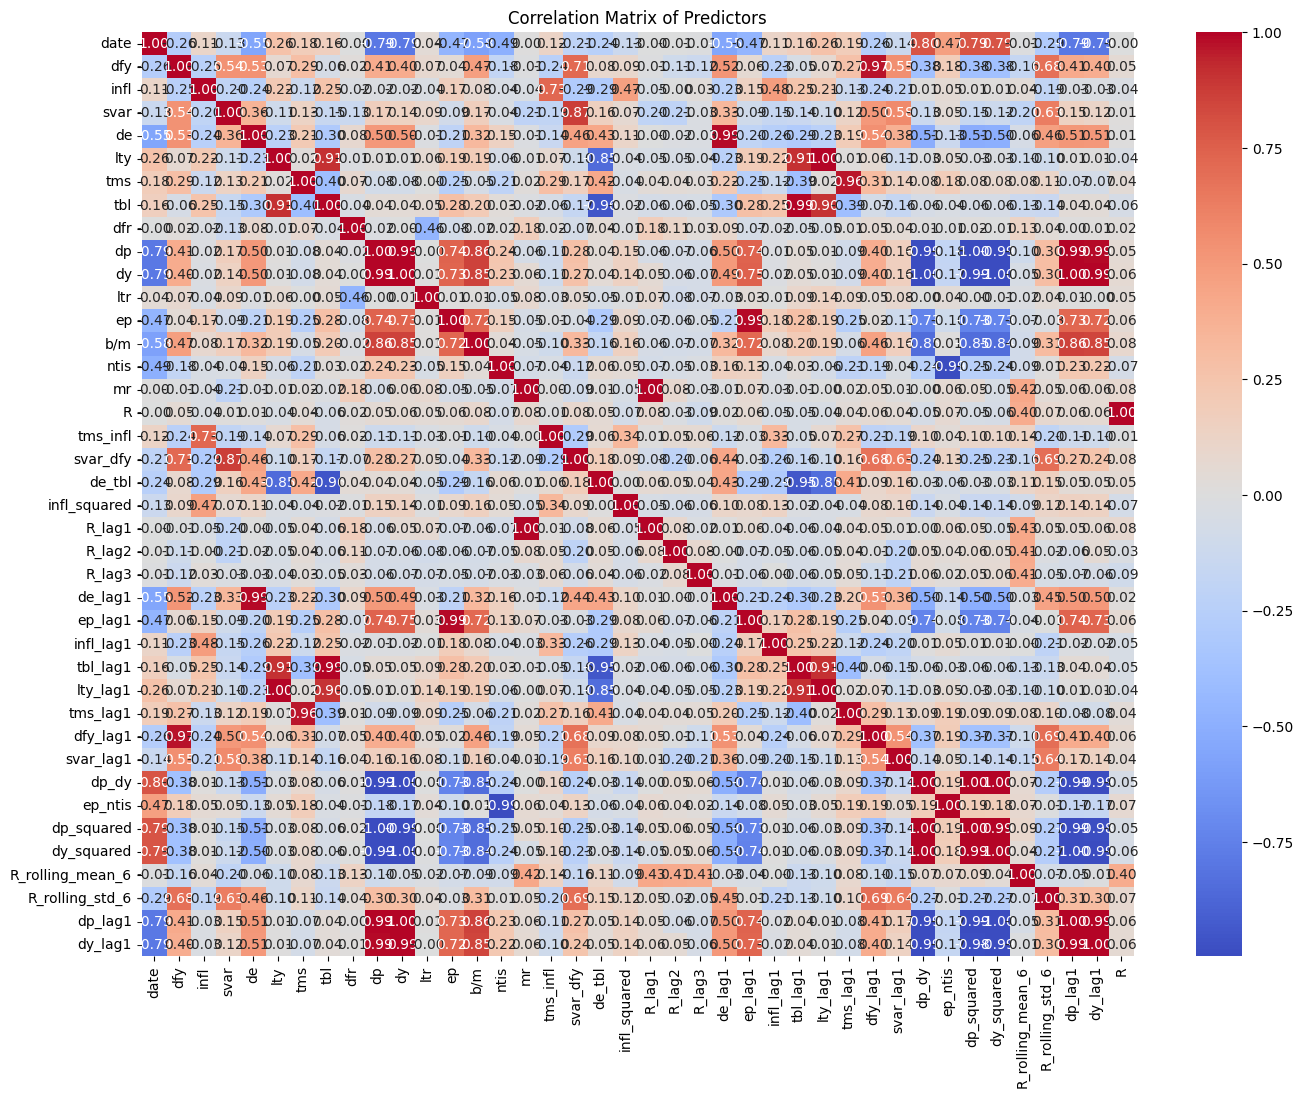

In [8]:
# Drop rows with NaNs caused by lagging
data = data.dropna()

# Reset the index
data.reset_index(drop=True, inplace=True)

# Correlation analysis after new features creation
correlations = data.corr()
correlations = correlations[[col for col in correlations if col != 'R'] + ['R']]
print(correlations['R'].sort_values(ascending=False))  # Correlation of all features with R

# Visualize correlations between predictors
plt.figure(figsize=(16, 12))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Predictors")
plt.show()

In [9]:


# Prepare predictors (X) and target (y)
X = data.drop(columns=["date", "R"])
y = data["R"]

# Split data into training (1926–2018) and testing (2019–2023) sets
# Ensure the split includes all data from 1926 to 2018 for training and 2019 to 2023 for testing
train_end = data[data['date'].dt.year == 2018].index[-1]
test_start = data[data['date'].dt.year == 2019].index[0]

X_train_unscaled, X_test_unscaled = X.loc[:train_end], X.loc[test_start:]
y_train, y_test = y.loc[:train_end], y.loc[test_start:]

# Print and check whether the split has happened correctly
print("Training set period:", data['date'].iloc[0], "to", data['date'].iloc[train_end])
print("Testing set period:", data['date'].iloc[train_end+1], "to", data['date'].iloc[-1])
print("Training set size:", X_train_unscaled.shape[0])
print("Testing set size:", X_test_unscaled.shape[0])

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train_unscaled)

# Transform the test data using the same scaler
X_test = scaler.transform(X_test_unscaled)

# Confirm split sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

print(data.shape)
print(X_train.shape)
print(X_train[:5])



Training set period: 1927-06-30 00:00:00 to 2018-12-31 00:00:00
Testing set period: 2019-01-31 00:00:00 to 2022-12-31 00:00:00
Training set size: 1099
Testing set size: 48
Training set: 1099 samples
Testing set: 48 samples
(1147, 40)
(1099, 38)
[[-2.80789253e-01 -4.65004992e-01 -4.30528766e-01  4.36579801e-01
  -6.59780373e-01 -1.37171873e+00 -1.93485395e-02 -9.01708872e-01
   7.65862155e-01  8.69303080e-01  2.55129373e-01  5.07300745e-01
  -4.98327652e-01  1.49855216e+00  9.76043558e-01 -2.95771996e-01
  -2.91373555e-01  3.17933481e-01 -2.78907098e-01  9.69617011e-01
   7.19761010e-02 -4.32443718e-02  3.79608143e-01  6.50424612e-01
  -1.54950429e+00 -2.53127997e-04 -6.38328536e-01 -1.37020136e+00
  -3.24040644e-01 -3.93357002e-01 -8.26354397e-01 -1.30532502e+00
  -7.81155421e-01 -8.69979694e-01  3.55929597e-01 -4.38417132e-01
   8.54349401e-01  8.84830661e-01]
 [-2.22930925e-01  6.28758863e-01 -3.55007796e-01  4.92980081e-01
  -6.34666347e-01 -1.11729401e+00 -1.03447287e-01  7.9244815

In [10]:
# Prepare test data for prediction, Reason- After the model is fit, the prediction for Y test data should happen on the preceeding month X data. 
# For example, if prediction of Y is done for Feb Month, the x data into fitted model should be of Jan Month. 
# And then the comparison should be between Feb month predicted Y and actual Y of Feb month.
# That is after the model is fit, before prediction by using the fitted model, first the x data of test data should be shifted by one row and 
# then delete the first row of the test data after shifting since no meaningful values in the first row after shifting. 
# For y data of test data, don't shift but just remove the first row for compatibility. Then do the prediction. 

# Print shape and head of test data before shifting
print("\nTest data before shifting:")
print(X_test.shape)
print(X_test[:5])
print(y_test.shape)
print(y_test.head())

# Shift the X_test data by one row
X_test_shifted = np.roll(X_test, shift=1, axis=0)

# Print shape and head of test data after shifting
print("\nTest data after shifting:")
print(X_test_shifted.shape)
print(X_test_shifted[:5])
print(y_test.shape)
print(y_test.head())

# Delete the first row after shifting
X_test_shifted = X_test_shifted[1:]

# Adjust y_test accordingly
y_test_shifted = np.array(y_test[1:])

print("\nTest data after deletion of first row:")
print(X_test_shifted.shape)
print(X_test_shifted[:5])
print(y_test_shifted.shape)
print(y_test_shifted[:5])


Test data before shifting:
(48, 38)
[[-0.02042678 -1.09877256  0.68635975 -0.80141325 -0.81405225 -0.96309721
  -0.32986699 -0.83598726 -0.99634803 -1.21997765  1.77595722 -0.47579643
  -1.12641637 -1.39582284 -1.84171717 -0.4361509   0.11829178  0.13473747
  -0.18679769 -1.82301548  0.20859592 -1.41663094 -0.81403686 -0.72025056
  -0.12926172 -0.3431356  -0.69573403 -0.67676415 -0.17939962 -0.00342021
   1.10508328  1.38155724  0.97949884  1.2306856  -0.82930413  0.34842619
  -1.22537414 -1.20289046]
 [ 0.09528987 -1.0693703   0.02654065 -0.79434833 -0.86069259 -1.06332513
  -0.32986699  1.41315224 -1.14396408 -0.99534757  0.13657021 -0.64553888
  -1.19403506 -1.39880628  1.32699519 -0.39261147 -0.1075931   0.13679648
  -0.19514587  1.33650405 -1.82292295  0.20753628 -0.80268795 -0.47706398
  -1.09628681 -0.33019664 -0.81413285 -0.96184389 -0.02029449  0.68666621
   1.06230701  1.4033157   1.14598611  0.97673548 -0.51131247  0.66162212
  -0.99858834 -1.22224361]
 [ 0.05189613 -0.1042

In [11]:
# The timing strategy function:
def timing_strategy_evaluation_with_drawdown(trained_model, X_test, actual_returns, risk_free_rate=0.02 / 12, threshold=0, initial_value=100):
    """
    Evaluate a timing strategy based on a trained model's predictions.

    Parameters:
        trained_model: Trained machine learning model with a `predict` method.
        X_test: DataFrame or array of predictors for testing (features for prediction).
        actual_returns: Series or array of actual returns for the evaluation period.
        risk_free_rate: Monthly risk-free rate, default is 0.02 annualized.
        threshold: Threshold for deciding risk-on or risk-off, default is 0.
        initial_value: Initial portfolio value, default is 100.

    Returns:
        portfolio_values: Series of portfolio values over time.
        cumulative_return: Final cumulative return of the portfolio.
        sharpe_ratio: Sharpe ratio of the portfolio strategy.
        max_drawdown: Maximum drawdown of the portfolio.
    """
    # Predict returns using the trained model
    predicted_returns = trained_model.predict(X_test)
   
    # Initialize portfolio for timing strategy
    portfolio_values_timing = [initial_value]

    # Timing strategy
    for i in range(len(predicted_returns)):
        if predicted_returns[i] > threshold:  # Risk-On
            portfolio_values_timing.append(portfolio_values_timing[-1] * (1 + actual_returns[i]))
        else:  # Risk-Off
            portfolio_values_timing.append(portfolio_values_timing[-1] * (1 + risk_free_rate))

    # Convert portfolio values to pandas Series for analysis
    portfolio_values_timing = pd.Series(portfolio_values_timing)

    # Calculate performance metrics for timing strategy
    cumulative_return_timing = portfolio_values_timing.iloc[-1] / portfolio_values_timing.iloc[0] - 1
    sharpe_ratio_timing = (portfolio_values_timing.pct_change().mean() - risk_free_rate) / portfolio_values_timing.pct_change().std()

    # Calculate maximum drawdown for timing strategy
    rolling_max_timing = portfolio_values_timing.cummax()
    drawdown_timing = (portfolio_values_timing - rolling_max_timing) / rolling_max_timing
    max_drawdown_timing = drawdown_timing.min()

    # Buy-and-hold strategy
    portfolio_values_bh = [initial_value]
    for ret in actual_returns:
        portfolio_values_bh.append(portfolio_values_bh[-1] * (1 + ret))
    portfolio_values_bh = pd.Series(portfolio_values_bh)

    # Plot portfolio evolution
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_values_timing, label="Timing Strategy", marker='o', linestyle='-')
    plt.plot(portfolio_values_bh, label="Buy-and-Hold Strategy", marker='x', linestyle='--')
    plt.title("Portfolio Evolution: Timing Strategy vs Buy-and-Hold")
    plt.xlabel("Time (Months)")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()

    return portfolio_values_timing, cumulative_return_timing, sharpe_ratio_timing, max_drawdown_timing

Linear Regression - Testing MSE: 0.0045, Testing R²: -0.4717
Linear Regression - Training MSE: 0.0016, Training R²: 0.4620


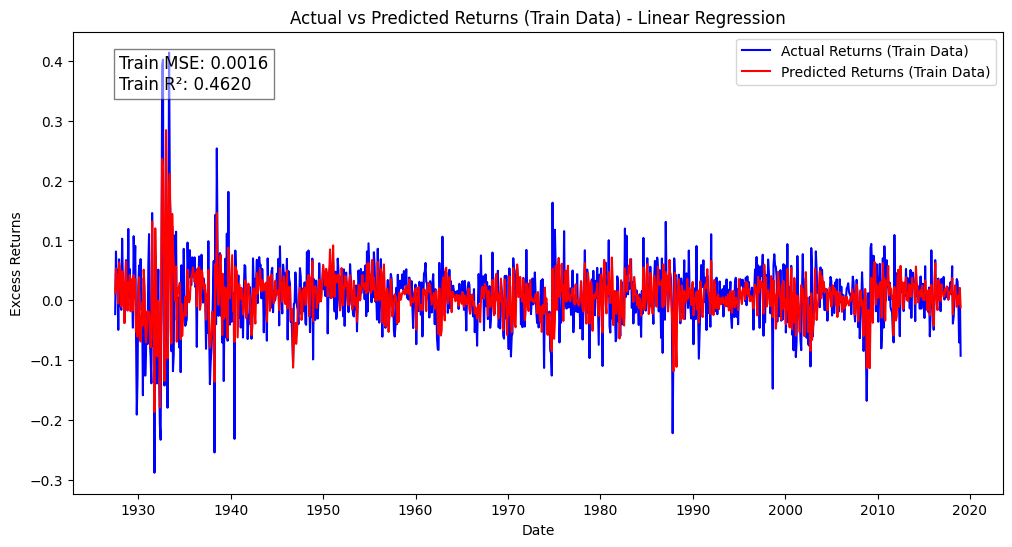

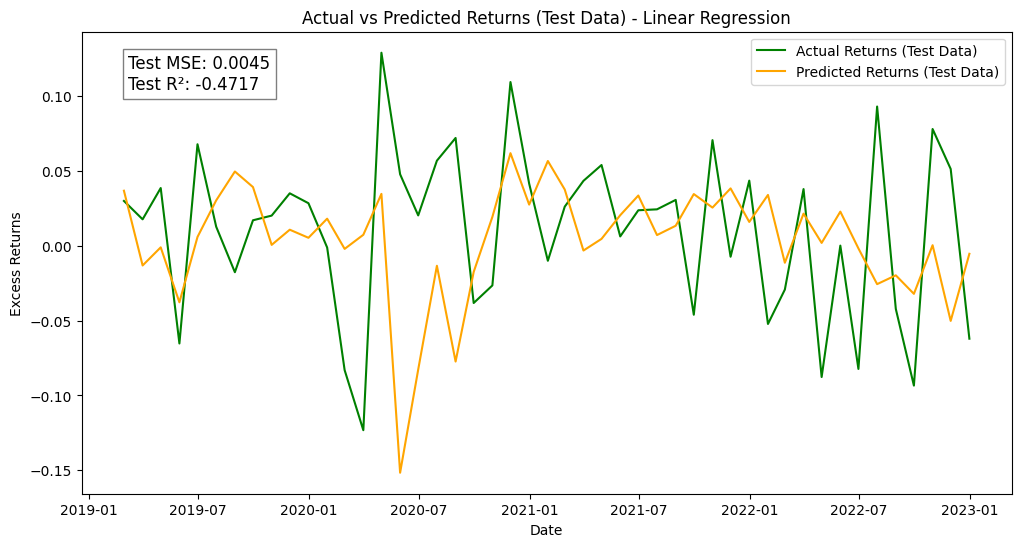

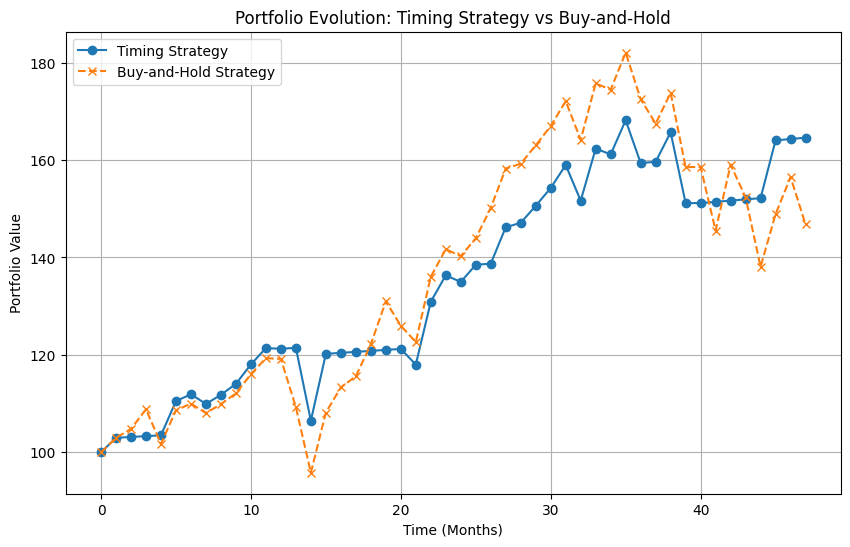

Cumulative Return: 64.59 %
Sharpe Ratio: 0.23
Maximum Drawdown: -12.32 %


In [12]:
# Initialize model_results list
model_results = []

# Implement Linear Regression without any penalty
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Predict and evaluate Linear Regression on shifted test data
y_test_pred_linear = linear_reg.predict(X_test_shifted)
mse_test_linear = mean_squared_error(y_test_shifted, y_test_pred_linear)
r2_test_linear = r2_score(y_test_shifted, y_test_pred_linear)
print(f"Linear Regression - Testing MSE: {mse_test_linear:.4f}, Testing R²: {r2_test_linear:.4f}")

# Predict and evaluate Linear Regression on training data
y_train_pred_linear = linear_reg.predict(X_train)
mse_train_linear = mean_squared_error(y_train, y_train_pred_linear)
r2_train_linear = r2_score(y_train, y_train_pred_linear)
print(f"Linear Regression - Training MSE: {mse_train_linear:.4f}, Training R²: {r2_train_linear:.4f}")

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue')
plt.plot(data['date'][:train_end+1], y_train_pred_linear, label="Predicted Returns (Train Data)", color='red')
plt.title("Actual vs Predicted Returns (Train Data) - Linear Regression")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(
    0.05, 0.95,
    f"Train MSE: {mse_train_linear:.4f}\nTrain R²: {r2_train_linear:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.5)
)
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green')
plt.plot(data['date'][train_end+2:], y_test_pred_linear, label="Predicted Returns (Test Data)", color='orange')
plt.title("Actual vs Predicted Returns (Test Data) - Linear Regression")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_linear:.4f}\nTest R²: {r2_test_linear:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()


# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    linear_reg, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")


#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "Linear Regression",
    "Train MSE": mse_train_linear,
    "Test MSE": mse_test_linear,
    "Train R²": r2_train_linear,
    "Test R²": r2_test_linear,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})


Ridge Regression - Testing MSE: 0.0033, Testing R²: -0.0899
Ridge Regression - Training MSE: 0.0019, Training R²: 0.3647


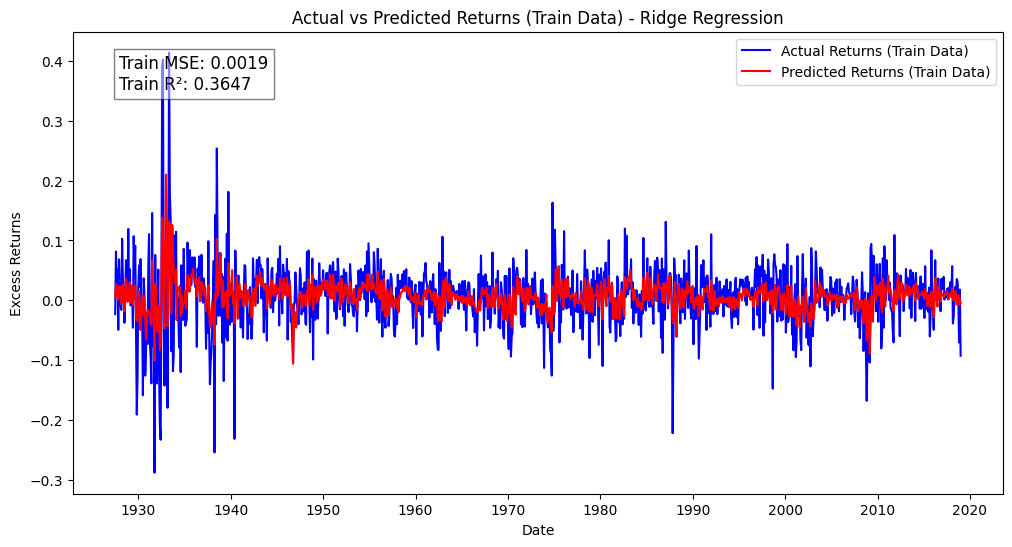

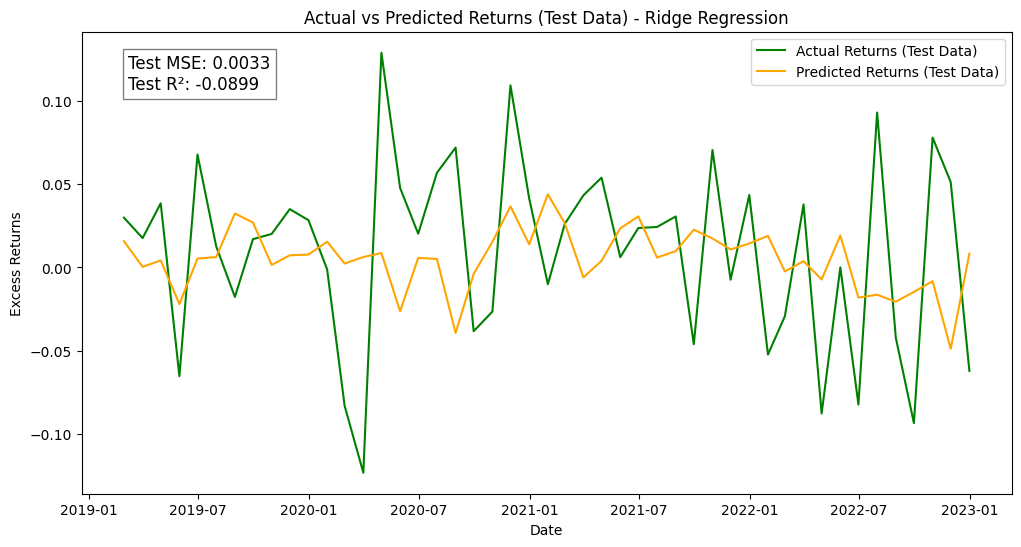

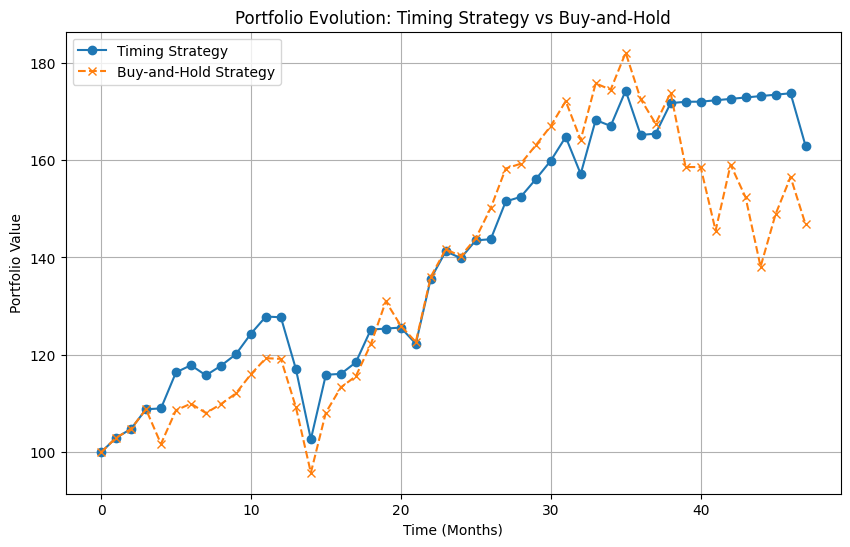

Cumulative Return: 62.92 %
Sharpe Ratio: 0.23
Maximum Drawdown: -19.7 %


In [13]:

# Ridge Regression
ridge_params = {"alpha": np.logspace(-6, 6, 100)}
ridge = Ridge(max_iter=10000, solver='saga')
ridge_grid = GridSearchCV(ridge, ridge_params, cv=TimeSeriesSplit(n_splits=6), scoring="neg_mean_squared_error")
ridge_grid.fit(X_train, y_train)

# Predict and evaluate Ridge Regression
y_test_pred_ridge = ridge_grid.predict(X_test_shifted)
mse_test_ridge = mean_squared_error(y_test_shifted, y_test_pred_ridge)
r2_test_ridge = r2_score(y_test_shifted, y_test_pred_ridge)
print(f"Ridge Regression - Testing MSE: {mse_test_ridge:.4f}, Testing R²: {r2_test_ridge:.4f}")

# Predict and evaluate Ridge Regression on training data
y_train_pred_ridge = ridge_grid.predict(X_train)
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
print(f"Ridge Regression - Training MSE: {mse_train_ridge:.4f}, Training R²: {r2_train_ridge:.4f}")

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue')
plt.plot(data['date'][:train_end+1], y_train_pred_ridge, label="Predicted Returns (Train Data)", color='red')
plt.title("Actual vs Predicted Returns (Train Data) - Ridge Regression")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Train MSE: {mse_train_ridge:.4f}\nTrain R²: {r2_train_ridge:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green')
plt.plot(data['date'][train_end+2:], y_test_pred_ridge, label="Predicted Returns (Test Data)", color='orange')
plt.title("Actual vs Predicted Returns (Test Data) - Ridge Regression")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_ridge:.4f}\nTest R²: {r2_test_ridge:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    ridge_grid, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "Ridge Regression",
    "Train MSE": mse_train_ridge,
    "Test MSE": mse_test_ridge,
    "Train R²": r2_train_ridge,
    "Test R²": r2_test_ridge,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.536e-01, tolerance: 1.651e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.915e-01, tolerance: 1.888e-04
  model = cd_fast.enet_coordinate_descent(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Best Lasso Alpha: {'alpha': np.float64(0.006579332246575682)}
Coefficients of predictors for the best estimator:
dfy                 0.000000
infl               -0.000000
svar                0.000000
de                  0.000000
lty                -0.000000
tms                 0.000000
tbl                -0.000000
dfr                -0.000000
dp                  0.000000
dy                  0.000000
ltr                 0.000000
ep                  0.000000
b/m                 0.000000
ntis               -0.000000
mr                 -0.000000
tms_infl           -0.000000
svar_dfy            0.000000
de_tbl              0.000000
infl_squared       -0.000000
R_lag1             -0.000000
R_lag2             -0.002129
R_lag3             -0.007174
de_lag1             0.000000
ep_lag1             0.000000
infl_lag1          -0.000000
tbl_lag1           -0.000000
lty_lag1           -0.000000
tms_lag1            0.000000
dfy_lag1            0.000000
svar_lag1           0.000000
dp_dy            

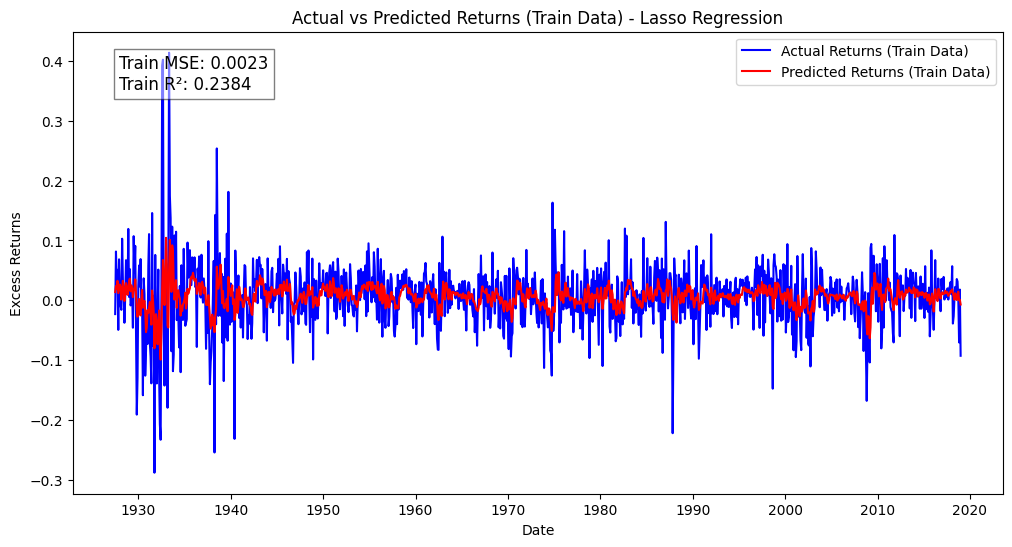

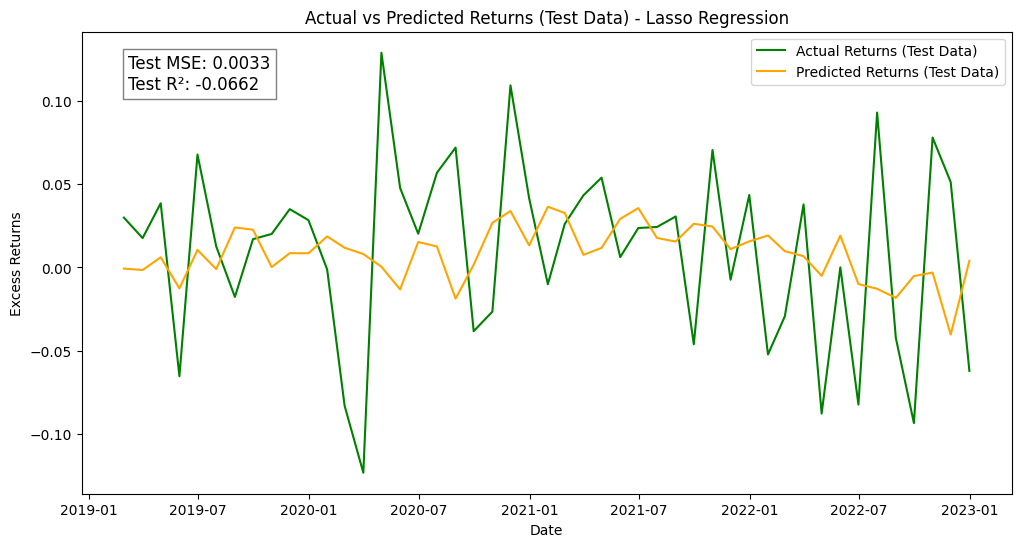

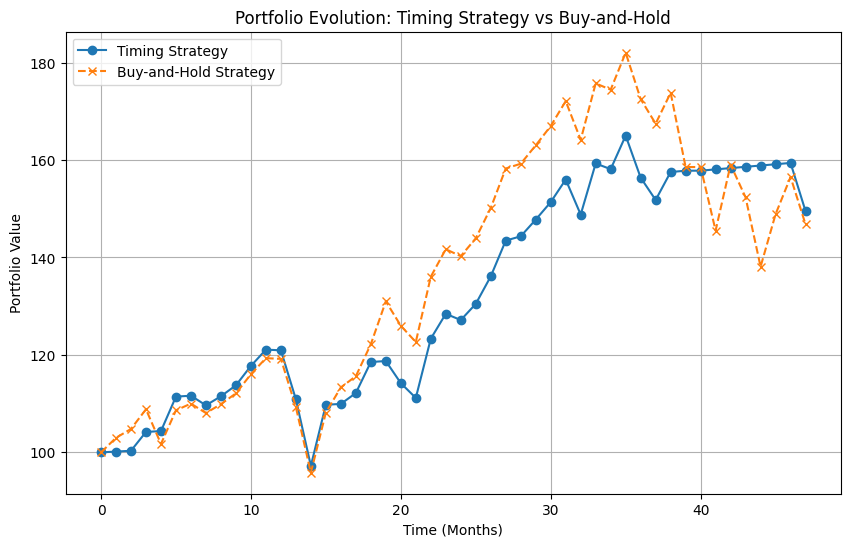

Cumulative Return: 49.51 %
Sharpe Ratio: 0.18
Maximum Drawdown: -19.7 %


In [14]:
# Lasso Regression
lasso_params = {"alpha": np.logspace(-8, 8, 100)}
lasso = Lasso(max_iter=20000)
lasso_grid = GridSearchCV(lasso, lasso_params, cv=TimeSeriesSplit(n_splits=6), scoring="neg_mean_squared_error")
lasso_grid.fit(X_train, y_train)

# Get the best parameters for Lasso
print("Best Lasso Alpha:", lasso_grid.best_params_)

# Print coefficients of predictors for the best estimator
print("Coefficients of predictors for the best estimator:")
print(pd.Series(lasso_grid.best_estimator_.coef_, index=X.columns))


# Predict and evaluate Lasso Regression on test data
y_test_pred_lasso = lasso_grid.predict(X_test_shifted)
mse_test_lasso = mean_squared_error(y_test_shifted, y_test_pred_lasso)
r2_test_lasso = r2_score(y_test_shifted, y_test_pred_lasso)
print(f"Lasso Regression - Testing MSE: {mse_test_lasso:.4f}, Testing R²: {r2_test_lasso:.4f}")

# Predict and evaluate Lasso Regression on training data
y_train_pred_lasso = lasso_grid.predict(X_train)
mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
print(f"Lasso Regression - Training MSE: {mse_train_lasso:.4f}, Training R²: {r2_train_lasso:.4f}")

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue')
plt.plot(data['date'][:train_end+1], y_train_pred_lasso, label="Predicted Returns (Train Data)", color='red')
plt.title("Actual vs Predicted Returns (Train Data) - Lasso Regression")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Train MSE: {mse_train_lasso:.4f}\nTrain R²: {r2_train_lasso:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green')
plt.plot(data['date'][train_end+2:], y_test_pred_lasso, label="Predicted Returns (Test Data)", color='orange')
plt.title("Actual vs Predicted Returns (Test Data) - Lasso Regression")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_lasso:.4f}\nTest R²: {r2_test_lasso:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()


# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    lasso_grid, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "Lasso Regression",
    "Train MSE": mse_train_lasso,
    "Test MSE": mse_test_lasso,
    "Train R²": r2_train_lasso,
    "Test R²": r2_test_lasso,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})


Best Random Forest Params: {'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 20}
Random Forest - Testing MSE: 0.0034, Testing R²: -0.0992
Random Forest - Training MSE: 0.0003, Training R²: 0.8946


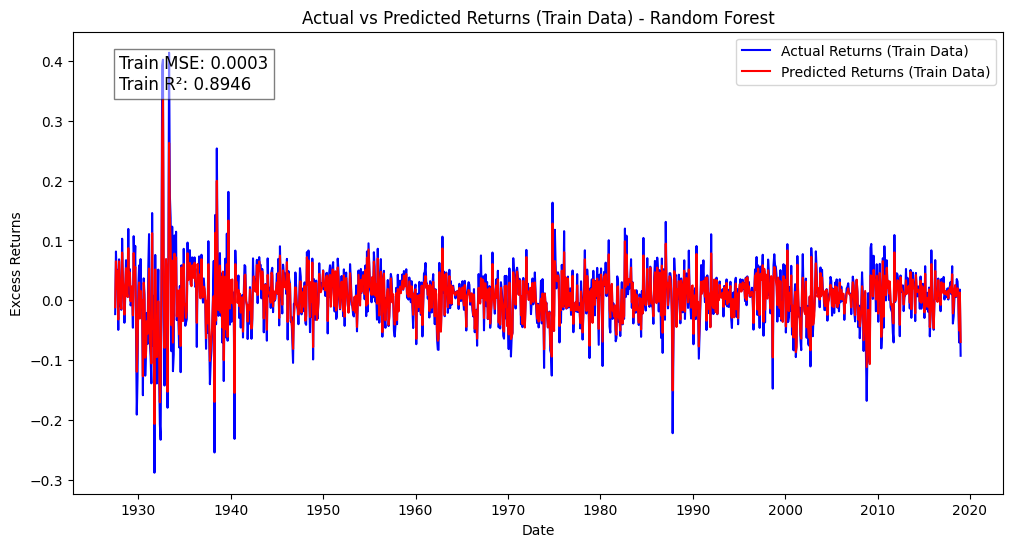

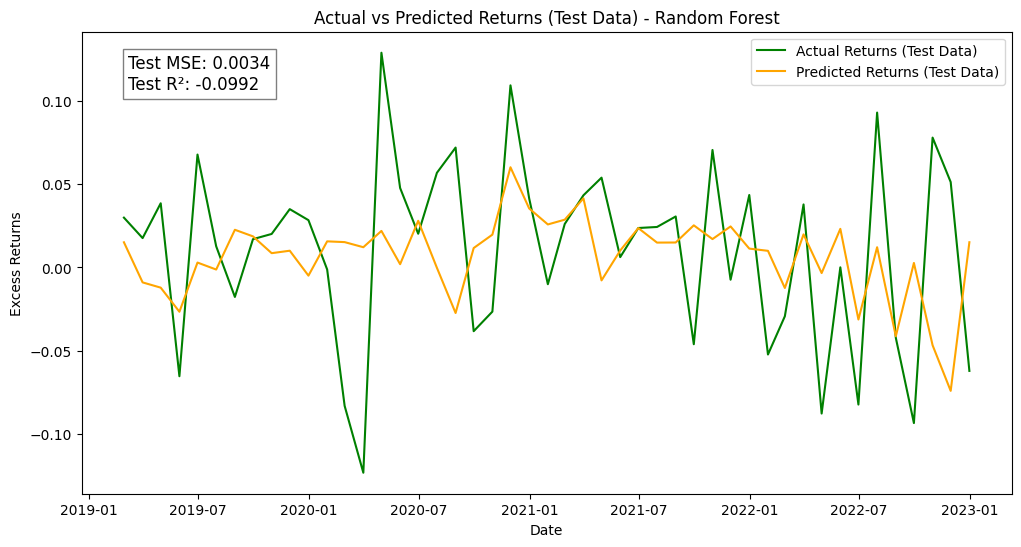

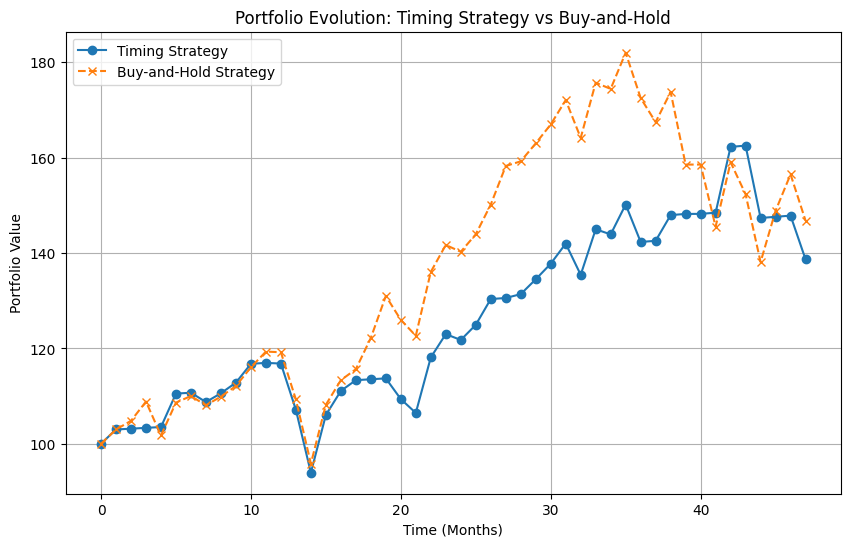

Cumulative Return: 38.67 %
Sharpe Ratio: 0.14
Maximum Drawdown: -19.7 %


In [15]:

# Implement Random Forest with extensive hyperparameter tuning
rf = RandomForestRegressor(random_state=42)
rf_params = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10, 15],
}
rf_random = RandomizedSearchCV(rf, rf_params, cv=TimeSeriesSplit(n_splits=6), scoring="neg_mean_squared_error", random_state=42, n_iter=50)
rf_random.fit(X_train, y_train)
print("Best Random Forest Params:", rf_random.best_params_)


# Predict and evaluate Random Forest
y_test_pred_rf = rf_random.predict(X_test_shifted)
mse_test_rf = mean_squared_error(y_test_shifted, y_test_pred_rf)
r2_test_rf = r2_score(y_test_shifted, y_test_pred_rf)
print(f"Random Forest - Testing MSE: {mse_test_rf:.4f}, Testing R²: {r2_test_rf:.4f}")

# Predict and evaluate Random Forest on training data
y_train_pred_rf = rf_random.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"Random Forest - Training MSE: {mse_train_rf:.4f}, Training R²: {r2_train_rf:.4f}")

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue')
plt.plot(data['date'][:train_end+1], y_train_pred_rf, label="Predicted Returns (Train Data)", color='red')
plt.title("Actual vs Predicted Returns (Train Data) - Random Forest")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Train MSE: {mse_train_rf:.4f}\nTrain R²: {r2_train_rf:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green')
plt.plot(data['date'][train_end+2:], y_test_pred_rf, label="Predicted Returns (Test Data)", color='orange')
plt.title("Actual vs Predicted Returns (Test Data) - Random Forest")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_rf:.4f}\nTest R²: {r2_test_rf:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    rf_random, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "Random Forest",
    "Train MSE": mse_train_rf,
    "Test MSE": mse_test_rf,
    "Train R²": r2_train_rf,
    "Test R²": r2_test_rf,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})


c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.554e-01, tolerance: 1.651e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\Administrator\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-01, tolerance: 1.888e-04 Linear regression models with null weight for the l1 regularization term are mor

Best Elastic Net Params: {'alpha': np.float64(0.04037017258596558), 'l1_ratio': np.float64(0.1111111111111111)}
Elastic Net - Testing MSE: 0.0034, Testing R²: -0.0958
Elastic Net - Training MSE: 0.0021, Training R²: 0.2887


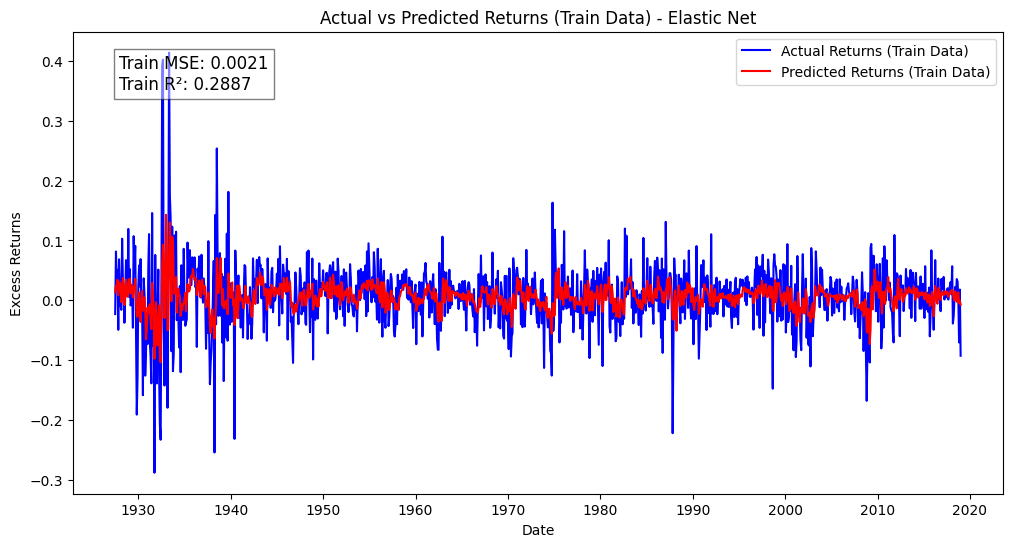

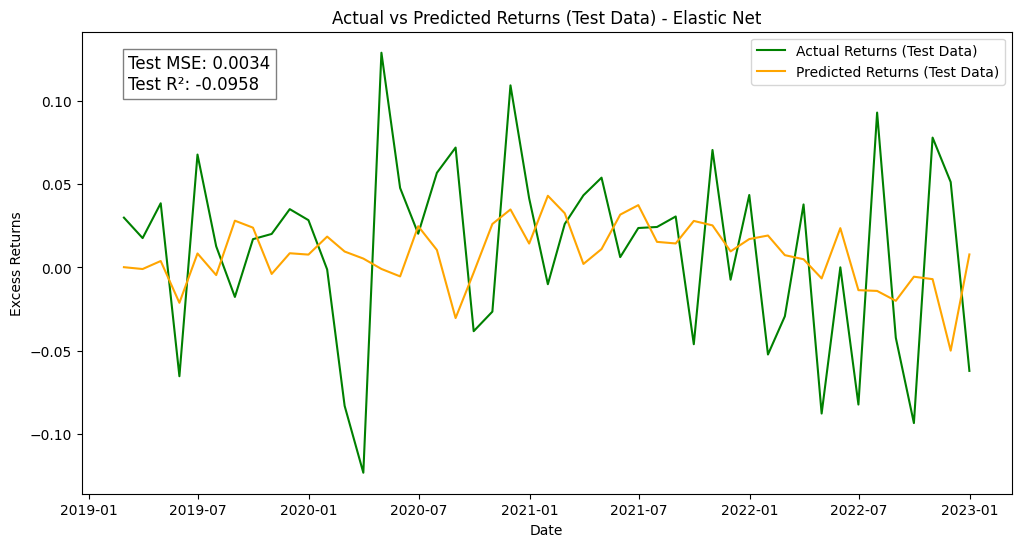

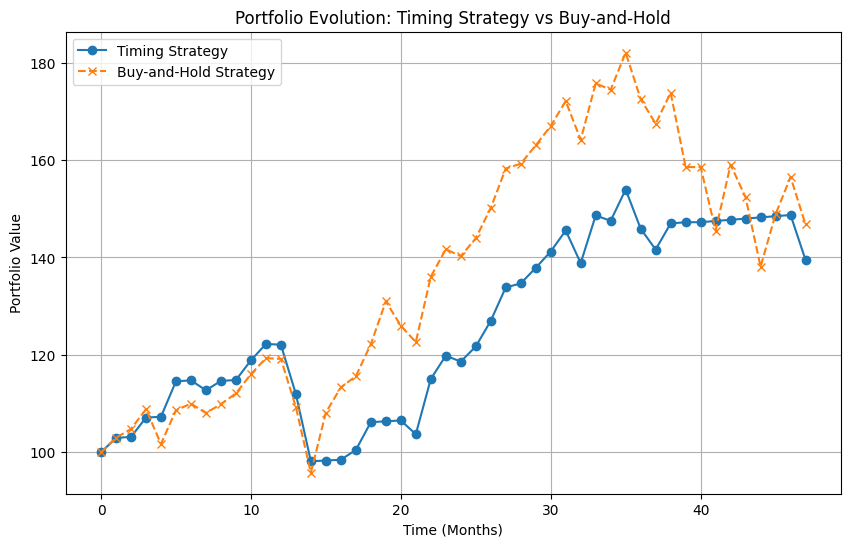

Cumulative Return: 39.49 %
Sharpe Ratio: 0.16
Maximum Drawdown: -19.7 %


In [16]:
# Define the parameter grid for Elastic Net
elastic_net_params = {
    "alpha": np.logspace(-6, 6, 100), # nolint: indentation_linter.
    "l1_ratio": np.linspace(0, 1, 10)
}

# Initialize Elastic Net
elastic_net = ElasticNet(max_iter=10000)

# Perform Grid Search with cross-validation
elastic_net_grid = GridSearchCV(elastic_net, elastic_net_params, cv=TimeSeriesSplit(n_splits=6), scoring="neg_mean_squared_error") # nolint
elastic_net_grid.fit(X_train, y_train)

# Get the best parameters for Elastic Net
print("Best Elastic Net Params:", elastic_net_grid.best_params_)


# Predict and evaluate Elastic Net on test data
y_test_pred_elastic_net = elastic_net_grid.predict(X_test_shifted)
mse_test_elastic_net = mean_squared_error(y_test_shifted, y_test_pred_elastic_net)
r2_test_elastic_net = r2_score(y_test_shifted, y_test_pred_elastic_net)
print(f"Elastic Net - Testing MSE: {mse_test_elastic_net:.4f}, Testing R²: {r2_test_elastic_net:.4f}") # nolint

# Predict and evaluate Elastic Net on training data
y_train_pred_elastic_net = elastic_net_grid.predict(X_train)
mse_train_elastic_net = mean_squared_error(y_train, y_train_pred_elastic_net)
r2_train_elastic_net = r2_score(y_train, y_train_pred_elastic_net)
print(f"Elastic Net - Training MSE: {mse_train_elastic_net:.4f}, Training R²: {r2_train_elastic_net:.4f}") # nolint

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue') # nolint
plt.plot(data['date'][:train_end+1], y_train_pred_elastic_net, label="Predicted Returns (Train Data)", color='red') # nolint
plt.title("Actual vs Predicted Returns (Train Data) - Elastic Net")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Train MSE: {mse_train_elastic_net:.4f}\nTrain R²: {r2_train_elastic_net:.4f}",  # nolint
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5)) # nolint
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green') # nolint
plt.plot(data['date'][train_end+2:], y_test_pred_elastic_net, label="Predicted Returns (Test Data)", color='orange') # nolint
plt.title("Actual vs Predicted Returns (Test Data) - Elastic Net")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_elastic_net:.4f}\nTest R²: {r2_test_elastic_net:.4f}",  # nolint
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5)) # nolint
plt.show()

# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    elastic_net_grid, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "Elastic Net",
    "Train MSE": mse_train_elastic_net,
    "Test MSE": mse_test_elastic_net,
    "Train R²": r2_train_elastic_net,
    "Test R²": r2_test_elastic_net,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})


Best XGBoost Params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
XGBoost - Training MSE: 0.0013, Training R²: 0.5497
XGBoost - Testing MSE: 0.0030, Testing R²: 0.0265


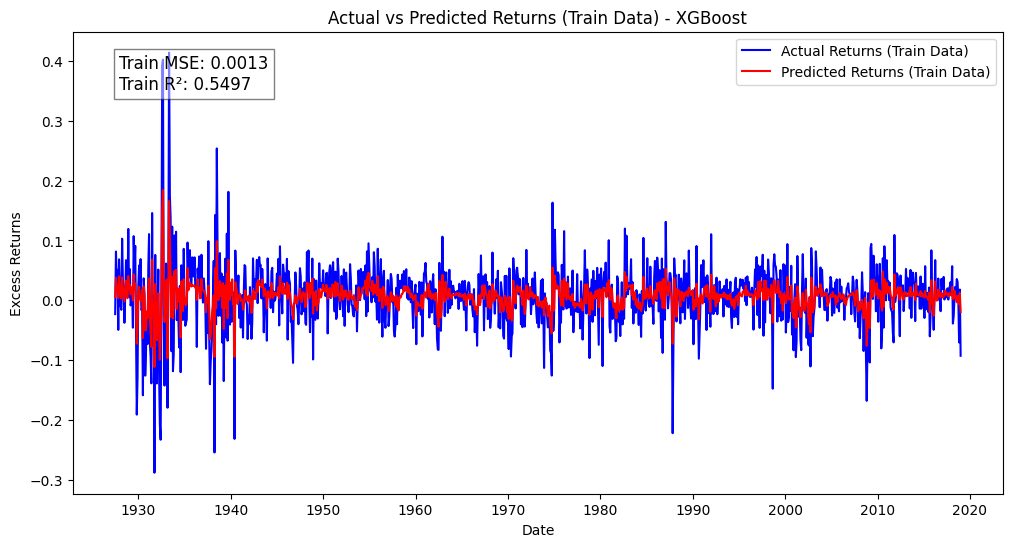

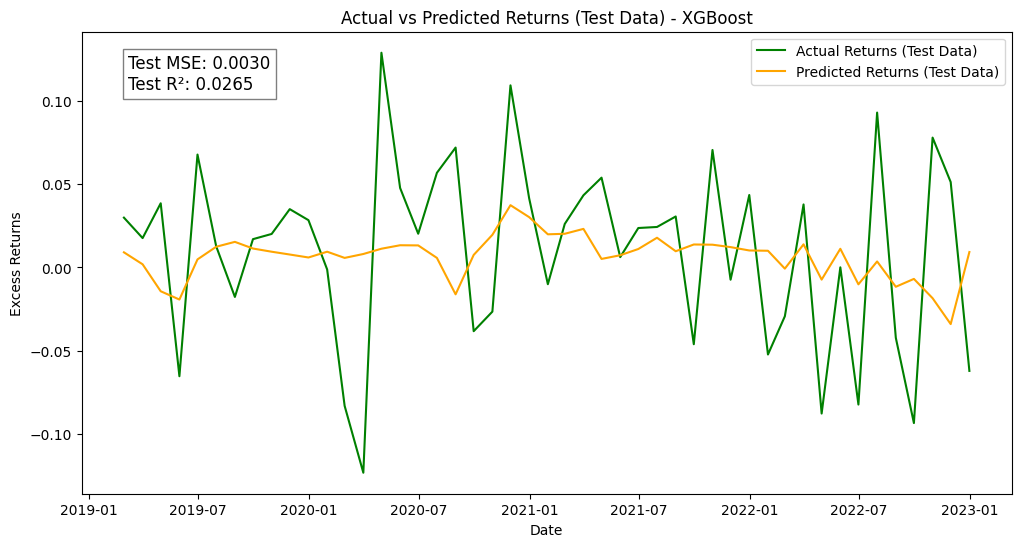

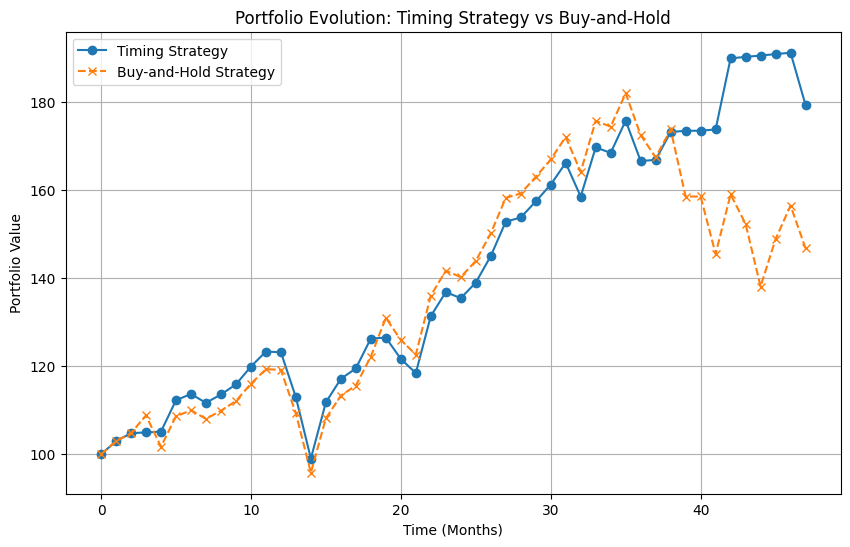

Cumulative Return: 79.35 %
Sharpe Ratio: 0.26
Maximum Drawdown: -19.7 %


In [17]:
# Implement XGBoost with extensive hyperparameter tuning
xgb = XGBRegressor(random_state=42)
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0]
}
xgb_random = RandomizedSearchCV(xgb, xgb_params, cv=TimeSeriesSplit(n_splits=5), scoring="neg_mean_squared_error", random_state=42, n_iter=50)
xgb_random.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_random.best_params_)

# Predict and evaluate XGBoost on training data
y_train_pred_xgb = xgb_random.predict(X_train)
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
print(f"XGBoost - Training MSE: {mse_train_xgb:.4f}, Training R²: {r2_train_xgb:.4f}")

# Predict and evaluate XGBoost on test data
y_test_pred_xgb = xgb_random.predict(X_test_shifted)
mse_test_xgb = mean_squared_error(y_test_shifted, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test_shifted, y_test_pred_xgb)
print(f"XGBoost - Testing MSE: {mse_test_xgb:.4f}, Testing R²: {r2_test_xgb:.4f}")

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue')
plt.plot(data['date'][:train_end+1], y_train_pred_xgb, label="Predicted Returns (Train Data)", color='red')
plt.title("Actual vs Predicted Returns (Train Data) - XGBoost")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Train MSE: {mse_train_xgb:.4f}\nTrain R²: {r2_train_xgb:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green')
plt.plot(data['date'][train_end+2:], y_test_pred_xgb, label="Predicted Returns (Test Data)", color='orange')
plt.title("Actual vs Predicted Returns (Test Data) - XGBoost")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_xgb:.4f}\nTest R²: {r2_test_xgb:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()


# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    xgb_random, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "XGBoost",
    "Train MSE": mse_train_xgb,
    "Test MSE": mse_test_xgb,
    "Train R²": r2_train_xgb,
    "Test R²": r2_test_xgb,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})



Stacking Regressor - Testing MSE: 0.0035, Testing R²: -0.1321
Stacking Regressor - Training MSE: 0.0009, Training R²: 0.7077


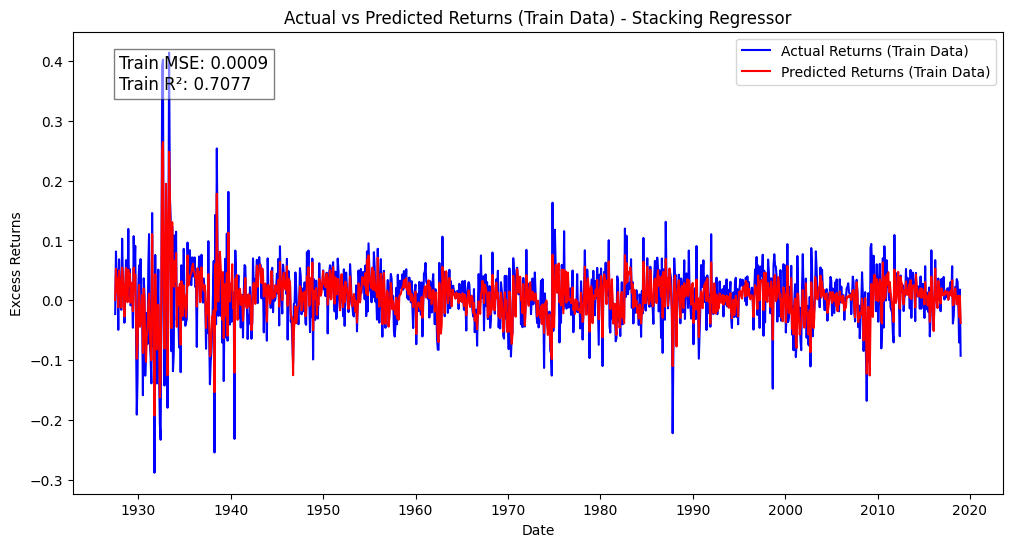

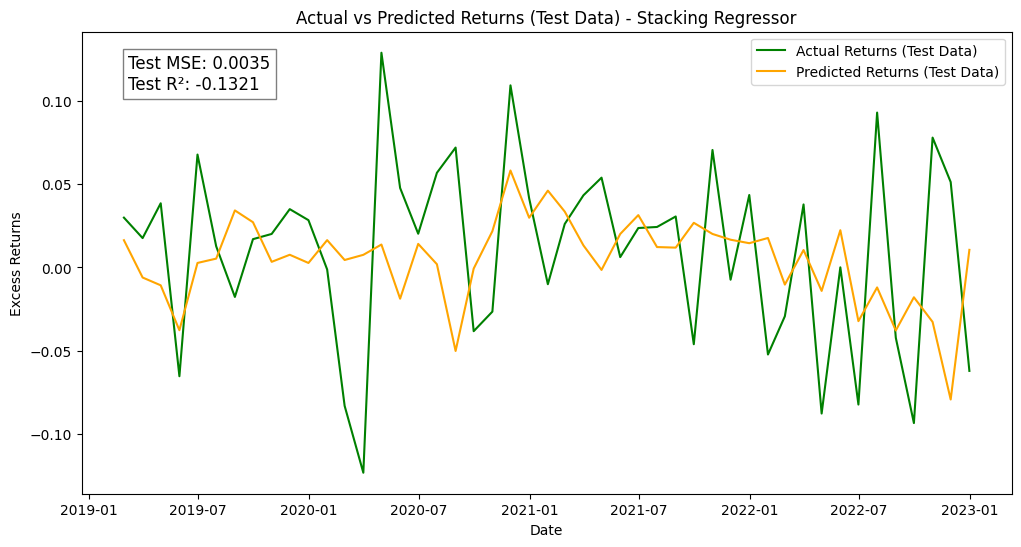

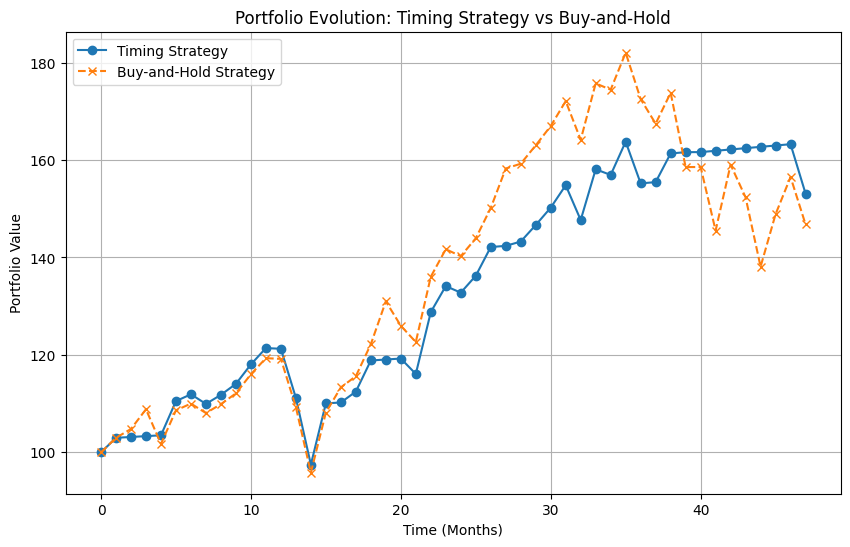

Cumulative Return: 53.12 %
Sharpe Ratio: 0.2
Maximum Drawdown: -19.7 %


In [18]:

# Ensemble Method: Stacking Regressor with additional models
stack = StackingRegressor(estimators=[
    ('ridge', ridge_grid.best_estimator_),
    ('rf', rf_random.best_estimator_),
    ('xgb', xgb_random.best_estimator_)
], final_estimator=LinearRegression())
stack.fit(X_train, y_train)

# Predict and evaluate Stacking Regressor on test data
y_test_pred_stack = stack.predict(X_test_shifted)
mse_test_stack = mean_squared_error(y_test_shifted, y_test_pred_stack)
r2_test_stack = r2_score(y_test_shifted, y_test_pred_stack)
print(f"Stacking Regressor - Testing MSE: {mse_test_stack:.4f}, Testing R²: {r2_test_stack:.4f}")

# Predict and evaluate Stacking Regressor on training data
y_train_pred_stack = stack.predict(X_train)
mse_train_stack = mean_squared_error(y_train, y_train_pred_stack)
r2_train_stack = r2_score(y_train, y_train_pred_stack)
print(f"Stacking Regressor - Training MSE: {mse_train_stack:.4f}, Training R²: {r2_train_stack:.4f}")

# Plot the comparison between predicted target and actual target for train data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:train_end+1], y_train, label="Actual Returns (Train Data)", color='blue')
plt.plot(data['date'][:train_end+1], y_train_pred_stack, label="Predicted Returns (Train Data)", color='red')
plt.title("Actual vs Predicted Returns (Train Data) - Stacking Regressor")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Train MSE: {mse_train_stack:.4f}\nTrain R²: {r2_train_stack:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Plot the comparison between predicted target and actual target for test data
plt.figure(figsize=(12, 6))
plt.plot(data['date'][train_end+2:], y_test_shifted, label="Actual Returns (Test Data)", color='green')
plt.plot(data['date'][train_end+2:], y_test_pred_stack, label="Predicted Returns (Test Data)", color='orange')
plt.title("Actual vs Predicted Returns (Test Data) - Stacking Regressor")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.text(0.05, 0.95, f"Test MSE: {mse_test_stack:.4f}\nTest R²: {r2_test_stack:.4f}", 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Run the strategy evaluation
portfolio_values, cumulative_return, sharpe_ratio, max_drawdown = timing_strategy_evaluation_with_drawdown(
    stack, X_test_shifted, y_test_shifted
)

# Display results
print("Cumulative Return:", round(cumulative_return * 100, 2), "%")
print("Sharpe Ratio:", round(sharpe_ratio, 2))
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

#Storing of results in a table
model_results.append({
    "S.No": len(model_results) + 1,
    "Model": "Stacking Regressor",
    "Train MSE": mse_train_stack,
    "Test MSE": mse_test_stack,
    "Train R²": r2_train_stack,
    "Test R²": r2_test_stack,
    "Cumulative Return (%)": round(cumulative_return * 100, 2),
    "Sharpe Ratio": round(sharpe_ratio, 2),
    "Max Drawdown (%)": round(max_drawdown * 100, 2)
})


Summary table depicting the results of all the models for comparison:


S.No               Model  Train MSE  Test MSE  Train R²   Test R²  \
0     1   Linear Regression   0.001595  0.004503  0.462032 -0.471720   
1     2    Ridge Regression   0.001884  0.003335  0.364702 -0.089884   
2     3    Lasso Regression   0.002258  0.003263  0.238390 -0.066228   
3     4       Random Forest   0.000312  0.003364  0.894626 -0.099236   
4     5         Elastic Net   0.002109  0.003353  0.288680 -0.095812   
5     6             XGBoost   0.001335  0.002979  0.549680  0.026479   
6     7  Stacking Regressor   0.000867  0.003464  0.707652 -0.132077   

   Cumulative Return (%)  Sharpe Ratio  Max Drawdown (%)  
0                  64.59          0.23            -12.32  
1                  62.92          0.23            -19.70  
2                  49.51          0.18            -19.70  
3                  38.67          0.14            -19.70  
4                  39.49          0.16            -19.70  
5                  79.35          0.26            -19.70  
6                  53.12          0.20            -19.70

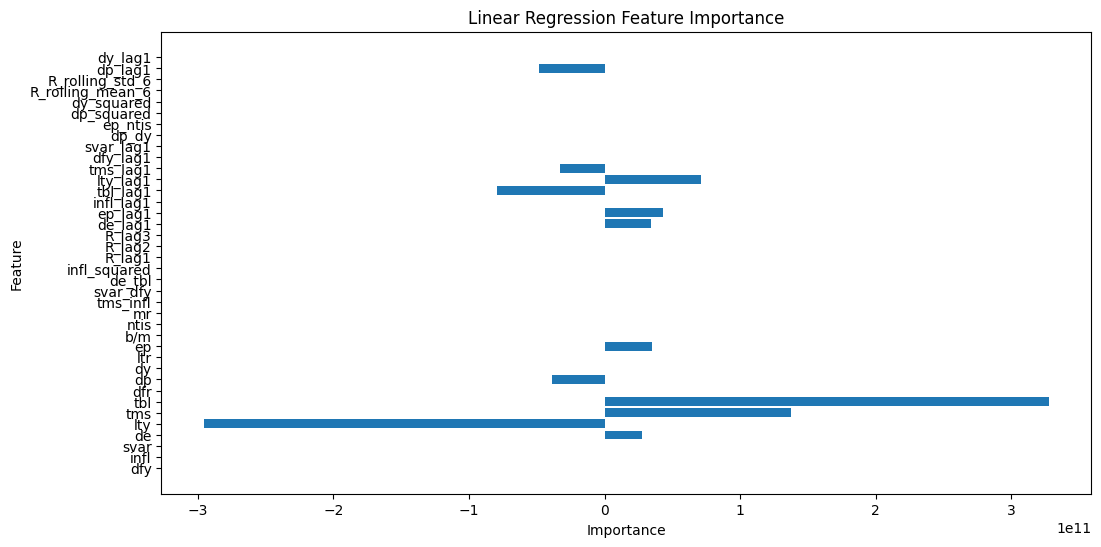

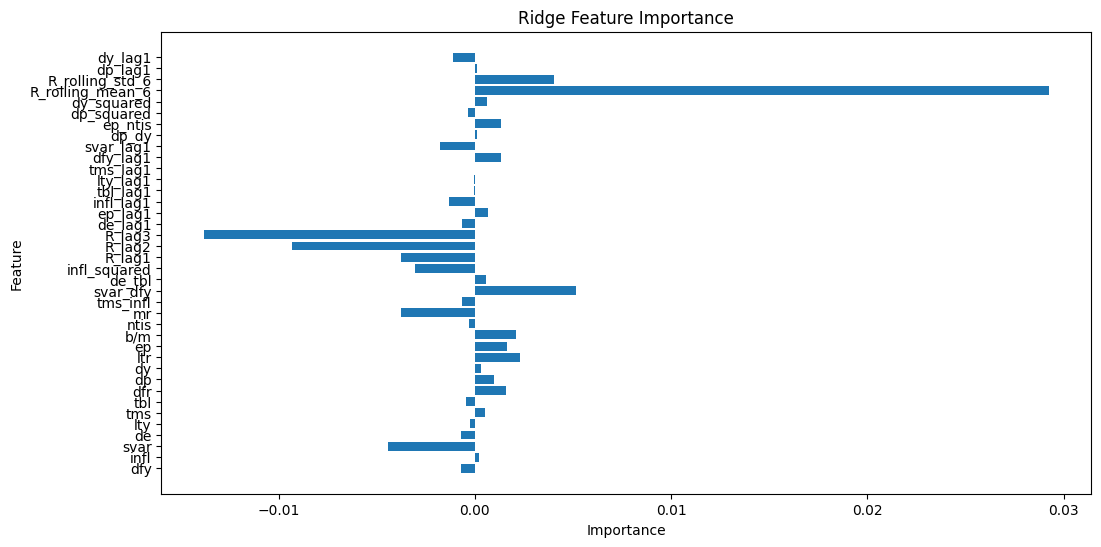

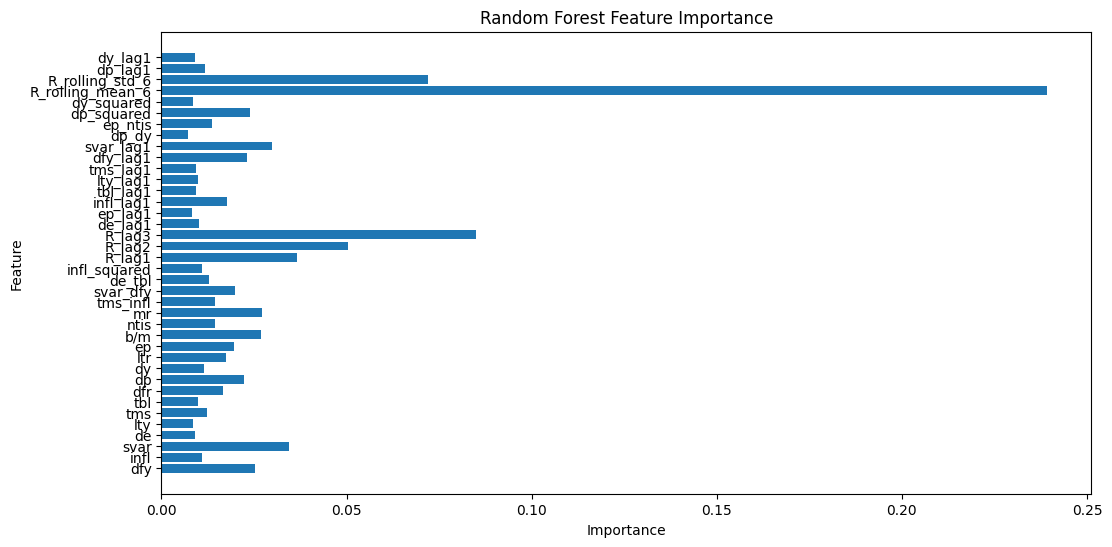

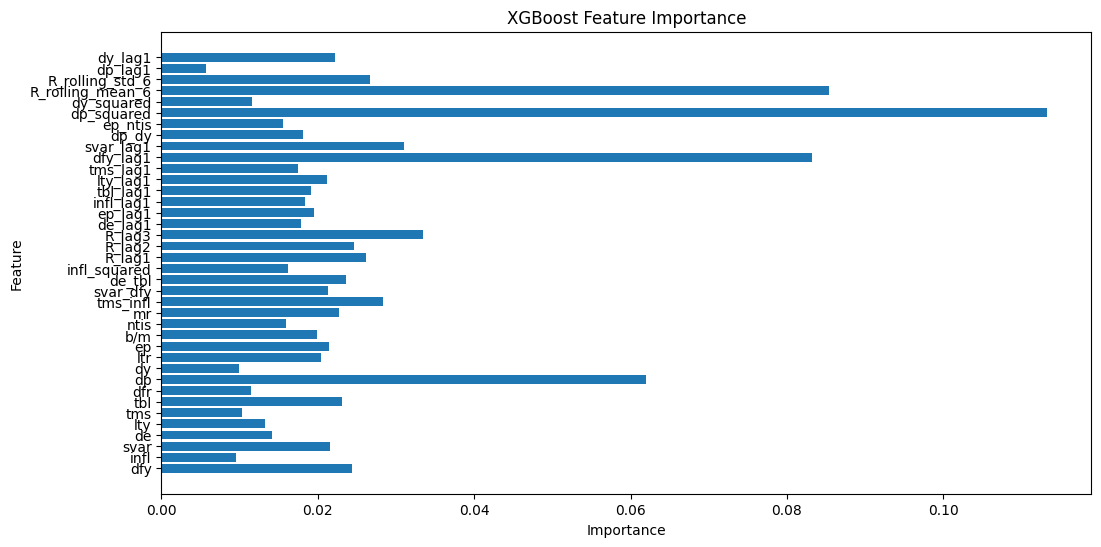

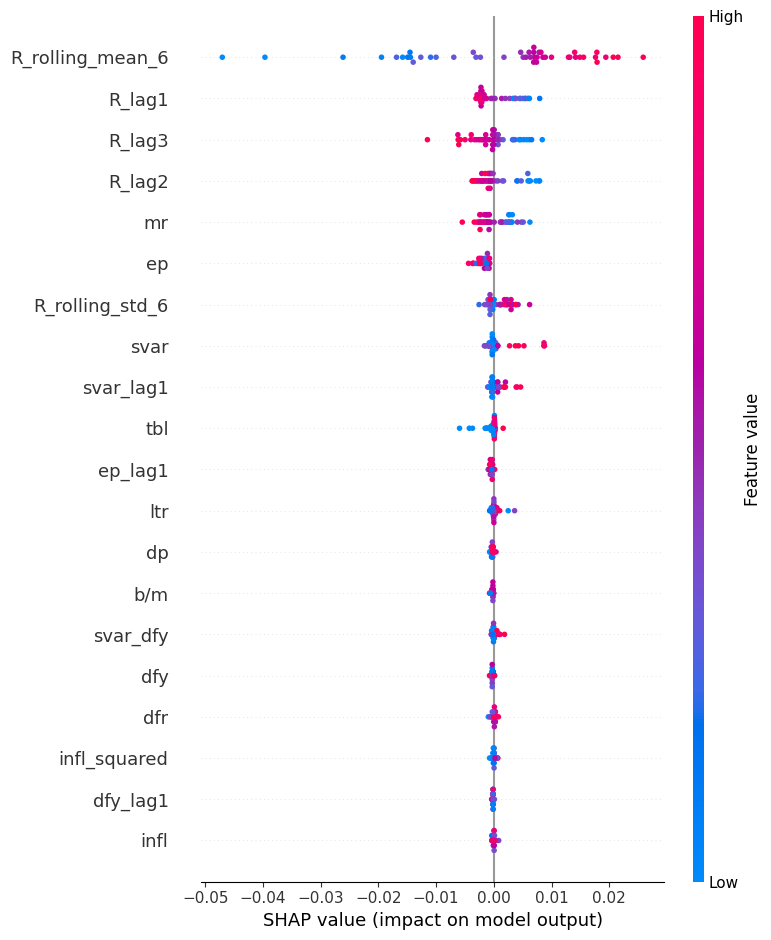

In [19]:
#Displaying the results for all the models
print("Summary table depicting the results of all the models for comparison:")
df_results = pd.DataFrame(model_results)
display(df_results)

# Feature Importance Plots for Random Forest and XGBoost
rf_best = rf_random.best_estimator_
xgb_best = xgb_random.best_estimator_
ridge_best = ridge_grid.best_estimator_

# Linear Regression Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(X.columns, linear_reg.coef_)
plt.title("Linear Regression Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# Ridge Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(X.columns, ridge_best.coef_)
plt.title("Ridge Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Random Forest Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(X.columns, rf_best.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(X.columns, xgb_best.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


# SHAP Analysis for XGBoost
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test_shifted)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_shifted, feature_names=X.columns)
